# Set up

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns

env = gym.make('CliffWalking-v0')

# Policy Iteration Agent

In [2]:
class PolicyIteration:
  def __init__(self,gamma=1,theta=0.0001,epsilon=0.1):
    self.gamma, self.epsilon = gamma, epsilon
    #theta is an approximation error threshold
    self.theta = theta

  def best_action(self, V, state):
    action_value_list = []
    for action in range(len(env.P[state])):
      prob, next_state, r, _ = env.P[state][action][0] #as the next state is deterministic for a state-action pair
      action_value = r + self.gamma * V[next_state]
      action_value_list.append(action_value)
    best_action = np.argmax(action_value_list)
    return best_action

  def update_policy(self, V):
    new_policy = []
    for state in range(env.nS):
      best_action = self.best_action(V, state)
      new_policy.append(best_action)
    return new_policy

  def update_V(self, V, state, policy):
    action = policy[state]
    prob, next_state, r, _ = env.P[state][action][0]
    new_state_value = r + self.gamma * V[next_state]
    return new_state_value
  
  def play(self, V, max_steps=70):
    t = 0
    state1 = env.reset() 
    done = False
    optimal_reward = 0
    while t < max_steps and not done:
      action1 = self.best_action(V, state1)
      state2, reward, done, info = env.step(action1)
      state1= state2
      t += 1
      optimal_reward += reward
    return optimal_reward

  def learning(self, max_iterations=50):
    V = np.random.rand(env.observation_space.n)
    V[-1] = 0 
    optimal_rewards_p = np.zeros(max_iterations)
    #initial a random policy that will be updated in each iteration
    policy = []
    for i in range(0,48):
      n = random.randint(0,3)
      policy.append(n)
    
    for i in range(max_iterations):
      #initial V_new and V_diff at the start of each iteration
      V_new = []
      V_diff = []

      #policy evaluation in each iteration
      for state in range(env.nS):
        new_state_value = self.update_V(V, state, policy) 
        value_diff = np.abs(new_state_value - V[state])
        V_new.append(new_state_value)
        V_diff.append(value_diff)
      
      #policy improvement in each iteration
      if np.max(V_diff[:-1]) > self.theta: 
        #update V
        V = V_new
        V[-1] = 0
        #update policy
        new_policy = self.update_policy(V)
        if policy == new_policy:
          r = i-1
          optimal_rewards_p[i:] = optimal_rewards_p[r]
          break #CHECK IF IT IS CORRECT TO BREAK HERE
        else:
          policy = new_policy
          optimal_reward = self.play(V)
          optimal_rewards_p[i] += optimal_reward
      else:
        r = i-1
        optimal_rewards_p[i:] = optimal_rewards_p[r]
        break #CHECK IF IT IS CORRECT TO BREAK HERE
        
    #return V at the end of the iteration
    return V, optimal_rewards_p
  

# Value Iteration Agent

In [3]:
class ValueIteration:
  def __init__(self,gamma=1,theta=0.0001,epsilon=0.1):
    self.gamma, self.epsilon = gamma, epsilon
    #theta is an approximation error threshold
    self.theta = theta

  def best_action(self, V, state):
    action_value_list = []
    for action in range(len(env.P[state])):
      prob, next_state, r, _ = env.P[state][action][0] #as the next state is deterministic for a state-action pair
      action_value = r + self.gamma * V[next_state]
      action_value_list.append(action_value)
    best_action = np.argmax(action_value_list)
    return best_action

  def new_V(self, V, state):
    best_action = self.best_action(V, state)
    prob, next_state, r, _ = env.P[state][best_action][0]
    new_state_value = r + self.gamma * V[next_state]
    return new_state_value
  
  def learning(self, max_iterations=50, max_steps=70):
    V = np.random.rand(env.observation_space.n)
    V[-1] = 0 
    optimal_rewards = np.zeros(max_iterations)

    for i in range(max_iterations):
      #initial V_new and V_diff at the start of each iteration
      V_new = []
      V_diff = []

      #sweep through all states in each iteration
      for state in range(env.nS):
        new_state_value = self.new_V(V, state)
        value_diff = np.abs(new_state_value - V[state])
        V_new.append(new_state_value)
        V_diff.append(value_diff)
      
      #decide to continue to next iteration or not
      if np.max(V_diff[:-1]) > self.theta: #Why V_diff last entry always is 1?
        V = V_new
        V[-1] = 0

        #play one episode with the latest V 
        t = 0
        state1 = env.reset() 
        done = False
        optimal_reward = 0

        while t < max_steps and not done:
          action1 = self.best_action(V, state1)
          state2, reward, done, info = env.step(action1)
          state1= state2
          t += 1
          optimal_reward += reward
        optimal_rewards[i] += optimal_reward

      else:
        r = i-1
        optimal_rewards[i:] = optimal_rewards[r] #V unchanged and optimal policy will be the same as before
        break
        
    #return V at the end of the iteration
    return V, optimal_rewards
  

# Training

In [4]:
p1 = PolicyIteration()
V_p, optimal_rewards_p = p1.learning()

v1 = ValueIteration()
V_v, optimal_rewards_v = v1.learning()


# Getting best policy

In [8]:
best_action_list = []
for state in range(env.nS):
  action_value_list = []
  for action in range(len(env.P[state])):
    prob, next_state, r, _ = env.P[state][action][0] 
    action_value = r + 1 * V_p[next_state]
    action_value_list.append(action_value)
    best_action = np.argmax(action_value_list)
  best_action_list.append(best_action)
    

In [9]:
import pandas as pd
actions = ["^", ">", "v", "<"]
policy_arrows = [actions[i] for i in best_action_list]
pd.DataFrame(np.array(policy_arrows).reshape(4,12))

,0,1,2,3,4,5,6,7,8,9,10,11
0,>,>,>,>,>,>,>,>,>,>,>,v
1,>,>,>,>,>,>,>,>,>,>,>,v
2,>,>,>,>,>,>,>,>,>,>,>,v
3,^,^,^,^,^,^,^,^,^,^,>,>


# Comparison between Policy Iteration and Value Iteration

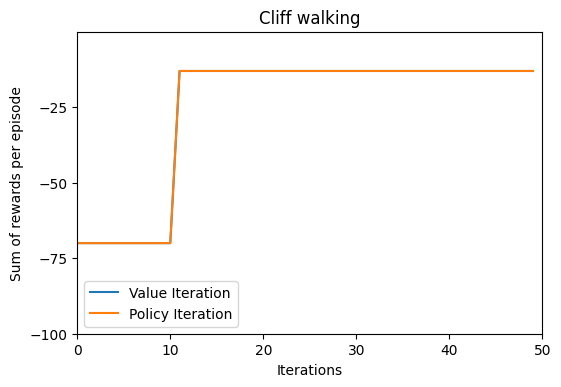

In [7]:
fig = plt.figure(dpi=100)
ax = plt.axes()
p_v_matrix = np.array([optimal_rewards_v, optimal_rewards_p]).transpose()
df = pd.DataFrame(p_v_matrix, columns = ["Value Iteration", "Policy Iteration"])

ax = sns.lineplot(data=df, x = df.index, y = "Value Iteration")
ax = sns.lineplot(data=df, x = df.index, y = "Policy Iteration")
ax.set(title="Cliff walking", xlabel="Iterations", ylabel = "Sum of rewards per episode", yticks = range(-100, 0, 25))
ax.set_ylim(-100,0)
ax.set_xlim(0,50)
ax.legend(["Value Iteration", "Policy Iteration"])